In [1]:
%env SM_FRAMEWORK=tf.keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import nibabel as nib
from PIL import Image
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
import cv2
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
import random
seed =0
random.seed(seed) 
tf.random.set_seed(seed)
np.random.seed(seed)
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

env: SM_FRAMEWORK=tf.keras


2023-04-04 13:49:29.650609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 13:49:32.077052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-04 13:49:32.077377: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-04 13:49:32.077384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Segmentation Models: using `tf.keras` framework.


In [2]:
def NormalizeData(data):
    Norm_data = []
    for i in range(data.shape[0]):
        norm = cv2.normalize(data[i],None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        Norm_data.append(norm)
        
    return np.array(Norm_data)
        

In [3]:
def binbary_label(data):
    bin_data = []
    for i in range(data.shape[0]):
        img = data[i]
        bin_img = np.where(img>0,1,img)
        bin_data.append(bin_img)
#         chk = np.where(bin_img==1)
#         if len(chk)>5:
#             bin_data.append(bin_img)
    return np.array(bin_data)

In [4]:
def LoadData(p1,p2):
    data_ = nib.load(p1).get_fdata()
    data = np.transpose(data_,(2,0,1))
    label_ = nib.load(p2).get_fdata()
    label = np.transpose(label_,(2,0,1))
    
    unmask = NormalizeData(data)
    mask = binbary_label(label)
    return unmask,mask

In [5]:
def split_filename(filepath):
    path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    base, ext = os.path.splitext(filename)
    if ext == '.gz':
        base, ext2 = os.path.splitext(base)
        ext = ext2 + ext
    return path, base, ext

def ProcessImage(path_file,mode='None',norm=True):
    dataset = []
    try:
        fns = sorted(glob.glob(path_file))
        for fn in fns:
            _, base, ext = split_filename(fn)
            img = nib.load(fn).get_data().astype(np.float32).squeeze()
            if img.ndim != 3:
                print(f'Only 3D data supported. File {base}{ext} has dimension {img.ndim}. Skipping.')
                continue
            
            if mode =='mask':
                for i in range(img.shape[2]):
                    r_img =  img[:,:,i]
                    r_img = np.where(r_img>0,1,r_img)
                    dataset.append(r_img)
            
            else:
                for i in range(img.shape[2]):
                    I = Image.fromarray(img[:,:,i], mode='F')

                    oldmin = np.min(I)
                    oldmax = np.max(I)
                    oldrange = oldmax-oldmin

                    newmin = 0
                    newmax = 255
                    newrange = newmax-newmin
                    scale =(I-oldmin)/oldrange
                    if norm:
                        normal_img = ((newrange*scale) + newmin)/255.
                    else:
                        normal_img = ((newrange*scale) + newmin)

                    dataset.append(normal_img)


        return np.array(dataset)
    except Exception as e:
        print(e)
        return 1


In [ ]:
def LoadData():
#     path_to_data = 'Task101_SCGM/imagesTr/*.nii*'
#     path_to_mask = 'Task101_SCGM/labelsTr/*.nii*'
    path_to_data = 'new_c/*.nii*'
    path_to_mask = 'new_s/*.nii*'
    unmask = ProcessImage(path_to_data,mode='unmask',norm=False)
    mask = ProcessImage(path_to_mask,mode='mask')
    return unmask,mask


In [ ]:
data,label = LoadData()

In [ ]:
Data = sorted(glob.glob('new_c/*'))
GT = sorted(glob.glob('new_s/*'))

data,label = LoadData(Data[2],GT[2])
print(data.shape)
print(label.shape)

In [6]:
import joblib as jlb
label,data=jlb.load("clean_mask_unmask")

In [7]:
unmask = np.expand_dims(data,axis=3)
mask = np.expand_dims(label,axis=3)

In [8]:
print(unmask.shape)
print(mask.shape)

(1736, 512, 512, 1)
(1736, 512, 512, 1)


In [9]:
def downsample(filters, size, shape, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer='he_normal'))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())

    return result

def upsample(filters, size, shape, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,padding='same',
                                    kernel_initializer='he_normal'))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.2))

    result.add(tf.keras.layers.ReLU())

    return result

In [10]:
OUTPUT_CHANNELS = 1
def buildUNet():
    inputs = tf.keras.layers.Input(shape=[512,512,1])
    down_stack = [
        downsample(64, 3, (None, 512, 512,1), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 3, (None, 256, 256, 64)), # (bs, 128, 128, 128)
        downsample(128, 3, (None, 128, 128, 128)), # (bs, 64, 64, 128)
        downsample(256, 3, (None, 64, 64, 128)),
        downsample(256, 3, (None, 32, 32, 256)), # (bs, 16, 16, 512)
        downsample(512, 3, (None, 16, 16, 256)), # (bs, 8, 8, 512)
        downsample(512, 3, (None, 8, 8, 512)), # (bs, 4, 4, 512)
        downsample(512, 3, (None, 4, 4, 512)), # (bs, 2, 2, 512)
        downsample(512, 3, (None, 2, 2, 512)), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 3, (None, 1, 1, 512), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 3, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 3, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 3, (None, 8, 8, 1024)), # (bs, 16, 16, 1024)
        upsample(256, 3, (None, 16, 16, 768)), # (bs, 32, 32, 512)
        upsample(256, 3, (None, 32, 32, 512)), # (bs, 64, 64, 256)
        upsample(128, 3, (None, 64, 64, 384)), # (bs, 128, 128, 128)
        upsample(128, 3, (None, 128, 128, 256)),
        upsample(64, 3, (None, 256, 256, 96)),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,strides=2,padding='same',
                                           kernel_initializer=initializer,
                                           activation='sigmoid') # (bs, 256, 256, 1)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(unmask,mask,test_size=0.2,random_state=0)

In [12]:
# *****************************************************

In [13]:
model = buildUNet()

2023-04-02 19:34:41.539024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 19:34:42.091702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38159 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


In [14]:
#m_optimizer = tf.keras.optimizers.Adam(2e-4)
# model.compile(optimizer = m_optimizer, loss = loss_object, metrics = ['accuracy'])
# focal_loss = sm.losses.BinaryFocalLoss()
# model.compile(optimizer='adam',loss=focal_loss,metrics=['accuracy'])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 128, 128, 12  74368       ['sequential[0][0]']             
                                8)                                                            

In [ ]:
# ****with kfold

Epoch 1/500


2023-04-02 19:35:10.258833: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_9/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-02 19:35:11.621005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-04-02 19:35:12.153796: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-02 19:35:13.482470: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x555571a7db70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-02 19:35:13.482507: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-04-02 19:35:13.488105: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash repro

87/87 - 24s - loss: 0.6717 - accuracy: 0.9487 - val_loss: 5.3223 - val_accuracy: 0.5531 - 24s/epoch - 273ms/step
Epoch 2/500
87/87 - 9s - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.0886 - val_accuracy: 0.9785 - 9s/epoch - 109ms/step
Epoch 3/500
87/87 - 9s - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.0248 - val_accuracy: 0.9914 - 9s/epoch - 109ms/step
Epoch 4/500
87/87 - 9s - loss: 0.0142 - accuracy: 0.9953 - val_loss: 0.0163 - val_accuracy: 0.9943 - 9s/epoch - 109ms/step
Epoch 5/500
87/87 - 10s - loss: 0.0127 - accuracy: 0.9957 - val_loss: 0.0150 - val_accuracy: 0.9949 - 10s/epoch - 109ms/step
Epoch 6/500
87/87 - 9s - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.0673 - val_accuracy: 0.9827 - 9s/epoch - 109ms/step
Epoch 7/500
87/87 - 10s - loss: 0.0101 - accuracy: 0.9965 - val_loss: 0.0222 - val_accuracy: 0.9925 - 10s/epoch - 111ms/step
Epoch 8/500
87/87 - 10s - loss: 0.0093 - accuracy: 0.9967 - val_loss: 0.0230 - val_accuracy: 0.9925 - 10s/epoch - 110ms/step
Epoch 9/500
87/87 - 

Epoch 67/500
87/87 - 10s - loss: 0.0047 - accuracy: 0.9979 - val_loss: 0.0076 - val_accuracy: 0.9972 - 10s/epoch - 110ms/step
Epoch 68/500
87/87 - 10s - loss: 0.0039 - accuracy: 0.9982 - val_loss: 0.0064 - val_accuracy: 0.9975 - 10s/epoch - 110ms/step
Epoch 69/500
87/87 - 10s - loss: 0.0036 - accuracy: 0.9983 - val_loss: 0.0058 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 70/500
87/87 - 10s - loss: 0.0033 - accuracy: 0.9985 - val_loss: 0.0060 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 71/500
87/87 - 10s - loss: 0.0031 - accuracy: 0.9986 - val_loss: 0.0056 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 72/500
87/87 - 10s - loss: 0.0030 - accuracy: 0.9986 - val_loss: 0.0054 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 73/500
87/87 - 10s - loss: 0.0029 - accuracy: 0.9987 - val_loss: 0.0055 - val_accuracy: 0.9979 - 10s/epoch - 111ms/step
Epoch 74/500
87/87 - 10s - loss: 0.0027 - accuracy: 0.9987 - val_loss: 0.0059 - val_accuracy: 0.9979 - 10s/epoch - 110

Epoch 132/500
87/87 - 10s - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0106 - val_accuracy: 0.9980 - 10s/epoch - 111ms/step
Epoch 133/500
87/87 - 10s - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0101 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 134/500
87/87 - 10s - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0106 - val_accuracy: 0.9980 - 10s/epoch - 111ms/step
Epoch 135/500
87/87 - 10s - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0112 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 136/500
87/87 - 10s - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0113 - val_accuracy: 0.9980 - 10s/epoch - 110ms/step
Epoch 137/500
87/87 - 10s - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0109 - val_accuracy: 0.9980 - 10s/epoch - 110ms/step
Epoch 138/500
87/87 - 10s - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0112 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 139/500
87/87 - 10s - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.0108 - val_accuracy: 0.9979 - 10s/epo

Epoch 196/500
87/87 - 10s - loss: 4.9089e-04 - accuracy: 0.9998 - val_loss: 0.0178 - val_accuracy: 0.9979 - 10s/epoch - 109ms/step
Epoch 197/500
87/87 - 10s - loss: 4.5127e-04 - accuracy: 0.9998 - val_loss: 0.0190 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 198/500
87/87 - 10s - loss: 4.4002e-04 - accuracy: 0.9998 - val_loss: 0.0201 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 199/500
87/87 - 10s - loss: 4.3823e-04 - accuracy: 0.9998 - val_loss: 0.0189 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 200/500
87/87 - 10s - loss: 4.6114e-04 - accuracy: 0.9998 - val_loss: 0.0193 - val_accuracy: 0.9979 - 10s/epoch - 109ms/step
Epoch 201/500
87/87 - 10s - loss: 4.6453e-04 - accuracy: 0.9998 - val_loss: 0.0199 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 202/500
87/87 - 10s - loss: 5.0484e-04 - accuracy: 0.9998 - val_loss: 0.0202 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 203/500
87/87 - 10s - loss: 5.3965e-04 - accuracy: 0.9998 - val_loss: 0.0197 

Epoch 259/500
87/87 - 10s - loss: 2.0722e-04 - accuracy: 0.9999 - val_loss: 0.0220 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 260/500
87/87 - 10s - loss: 1.4108e-04 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 261/500
87/87 - 10s - loss: 1.1220e-04 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 262/500
87/87 - 10s - loss: 9.2051e-05 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 263/500
87/87 - 10s - loss: 8.4681e-05 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 264/500
87/87 - 10s - loss: 8.6709e-05 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 265/500
87/87 - 10s - loss: 1.1095e-04 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 266/500
87/87 - 10s - loss: 2.5692e-04 - accuracy: 0.9999 - val_loss: 0.0274 

Epoch 322/500
87/87 - 10s - loss: 2.1526e-04 - accuracy: 0.9999 - val_loss: 0.0228 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 323/500
87/87 - 10s - loss: 1.3686e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 324/500
87/87 - 10s - loss: 1.0971e-04 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 325/500
87/87 - 10s - loss: 7.3080e-05 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 326/500
87/87 - 10s - loss: 4.6448e-05 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 327/500
87/87 - 10s - loss: 3.5685e-05 - accuracy: 1.0000 - val_loss: 0.0271 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 328/500
87/87 - 10s - loss: 3.7309e-05 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 329/500
87/87 - 10s - loss: 5.1397e-05 - accuracy: 1.0000 - val_loss: 0.0279 

Epoch 385/500
87/87 - 10s - loss: 1.4428e-04 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 386/500
87/87 - 10s - loss: 1.1088e-04 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9978 - 10s/epoch - 111ms/step
Epoch 387/500
87/87 - 10s - loss: 9.0093e-05 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 388/500
87/87 - 10s - loss: 7.4672e-05 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 389/500
87/87 - 10s - loss: 6.2527e-05 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 390/500
87/87 - 10s - loss: 5.6729e-05 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 391/500
87/87 - 10s - loss: 4.8577e-05 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 392/500
87/87 - 10s - loss: 4.7766e-05 - accuracy: 1.0000 - val_loss: 0.0249 

Epoch 448/500
87/87 - 10s - loss: 2.4193e-05 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 449/500
87/87 - 10s - loss: 3.1205e-05 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 450/500
87/87 - 10s - loss: 5.1665e-05 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 451/500
87/87 - 10s - loss: 9.4377e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 452/500
87/87 - 10s - loss: 2.1380e-04 - accuracy: 0.9999 - val_loss: 0.0293 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 453/500
87/87 - 10s - loss: 4.4421e-04 - accuracy: 0.9999 - val_loss: 0.0255 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 454/500
87/87 - 10s - loss: 3.8381e-04 - accuracy: 0.9999 - val_loss: 0.0251 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 455/500
87/87 - 10s - loss: 2.0174e-04 - accuracy: 0.9999 - val_loss: 0.0242 

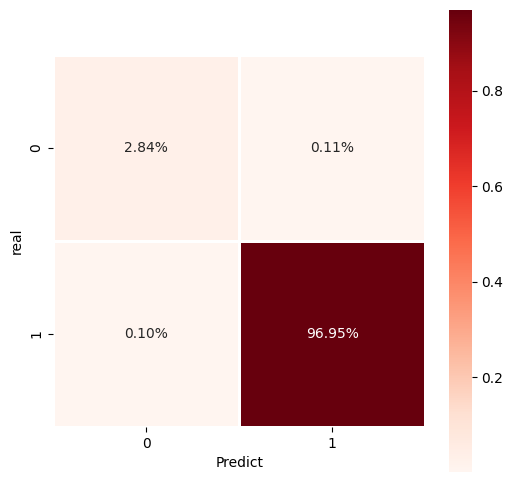

presicion:  0.9651760374605418
recall:  0.9612051541182416
F1-Score:  0.9631865031636468
Pixel_accuracy:  0.9978322544317136
dice:  0.9631865031636468
IoU:  0.9289872345437576
11/11 [==============================] - 1s 67ms/step - loss: 0.0315 - accuracy: 0.9978

result:	 [0.031452763825654984, 0.9978322982788086] 

Epoch 1/500
87/87 - 12s - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0836 - val_accuracy: 0.9927 - 12s/epoch - 133ms/step
Epoch 2/500
87/87 - 10s - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.0035 - val_accuracy: 0.9986 - 10s/epoch - 111ms/step
Epoch 3/500
87/87 - 10s - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0016 - val_accuracy: 0.9994 - 10s/epoch - 111ms/step
Epoch 4/500
87/87 - 10s - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0013 - val_accuracy: 0.9995 - 10s/epoch - 111ms/step
Epoch 5/500
87/87 - 10s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 0.9996 - 10s/epoch - 111ms/step
Epoch 6/500
87/87 - 10s - loss: 0.0012 - accuracy: 0.999

Epoch 62/500
87/87 - 10s - loss: 1.9526e-04 - accuracy: 0.9999 - val_loss: 0.0025 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 63/500
87/87 - 10s - loss: 1.2392e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 64/500
87/87 - 10s - loss: 7.8958e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 65/500
87/87 - 10s - loss: 6.7180e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 66/500
87/87 - 10s - loss: 4.4140e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9995 - 10s/epoch - 110ms/step
Epoch 67/500
87/87 - 10s - loss: 3.2106e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 68/500
87/87 - 10s - loss: 2.7212e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9995 - 10s/epoch - 110ms/step
Epoch 69/500
87/87 - 10s - loss: 2.0323e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_ac

Epoch 125/500
87/87 - 10s - loss: 4.6471e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9993 - 10s/epoch - 110ms/step
Epoch 126/500
87/87 - 10s - loss: 3.2035e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9993 - 10s/epoch - 110ms/step
Epoch 127/500
87/87 - 10s - loss: 2.1543e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 128/500
87/87 - 10s - loss: 1.5680e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 129/500
87/87 - 10s - loss: 1.2366e-05 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 130/500
87/87 - 10s - loss: 1.3313e-05 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 131/500
87/87 - 10s - loss: 1.1806e-05 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 132/500
87/87 - 10s - loss: 1.0699e-05 - accuracy: 1.0000 - val_loss: 0.0035 

Epoch 188/500
87/87 - 10s - loss: 1.5762e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 189/500
87/87 - 10s - loss: 5.7672e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 190/500
87/87 - 10s - loss: 2.4494e-05 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 191/500
87/87 - 10s - loss: 1.5916e-05 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 192/500
87/87 - 10s - loss: 1.0588e-05 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 193/500
87/87 - 10s - loss: 8.6025e-06 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 194/500
87/87 - 10s - loss: 7.4568e-06 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 195/500
87/87 - 10s - loss: 6.0451e-06 - accuracy: 1.0000 - val_loss: 0.0041 

Epoch 251/500
87/87 - 10s - loss: 8.9848e-05 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 252/500
87/87 - 10s - loss: 7.1783e-05 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 253/500
87/87 - 10s - loss: 6.1505e-05 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 254/500
87/87 - 10s - loss: 9.2643e-05 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 255/500
87/87 - 10s - loss: 6.9936e-05 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 256/500
87/87 - 10s - loss: 4.2395e-05 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 257/500
87/87 - 10s - loss: 2.3476e-05 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9992 - 10s/epoch - 112ms/step
Epoch 258/500
87/87 - 10s - loss: 1.6969e-05 - accuracy: 1.0000 - val_loss: 0.0049 

Epoch 314/500
87/87 - 10s - loss: 1.9840e-05 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 315/500
87/87 - 10s - loss: 2.0265e-05 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 316/500
87/87 - 10s - loss: 2.0718e-05 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 317/500
87/87 - 10s - loss: 1.6552e-05 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 318/500
87/87 - 10s - loss: 1.7413e-05 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 319/500
87/87 - 10s - loss: 6.0286e-05 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9987 - 10s/epoch - 111ms/step
Epoch 320/500
87/87 - 10s - loss: 2.9189e-04 - accuracy: 0.9999 - val_loss: 0.0059 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 321/500
87/87 - 10s - loss: 1.7025e-04 - accuracy: 0.9999 - val_loss: 0.0051 

Epoch 377/500
87/87 - 10s - loss: 1.4710e-05 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 378/500
87/87 - 10s - loss: 1.3319e-05 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 379/500
87/87 - 10s - loss: 1.1915e-05 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 380/500
87/87 - 10s - loss: 1.0881e-05 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 381/500
87/87 - 10s - loss: 9.1371e-06 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 382/500
87/87 - 10s - loss: 8.5715e-06 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 383/500
87/87 - 10s - loss: 5.8766e-06 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 384/500
87/87 - 10s - loss: 3.6762e-06 - accuracy: 1.0000 - val_loss: 0.0060 

Epoch 440/500
87/87 - 10s - loss: 9.0065e-07 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 441/500
87/87 - 10s - loss: 8.4333e-07 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 442/500
87/87 - 10s - loss: 9.5577e-07 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 443/500
87/87 - 10s - loss: 2.2720e-06 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 444/500
87/87 - 10s - loss: 2.5126e-06 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 445/500
87/87 - 10s - loss: 3.0850e-06 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 446/500
87/87 - 10s - loss: 1.8324e-06 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 447/500
87/87 - 10s - loss: 1.5724e-06 - accuracy: 1.0000 - val_loss: 0.0065 

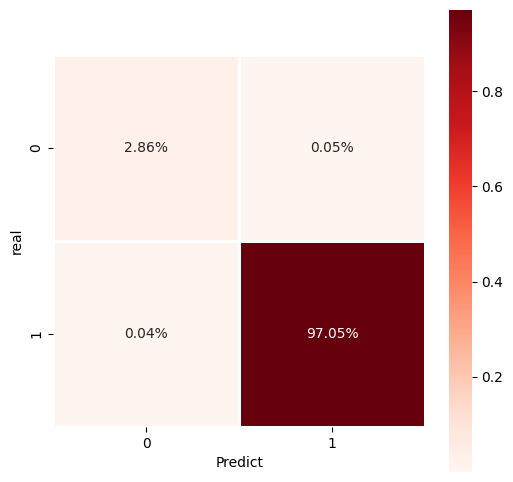

presicion:  0.9849629020211479
recall:  0.9840216383038278
F1-Score:  0.9844920451791609
Pixel_accuracy:  0.999100226146687
dice:  0.9844920451791609
IoU:  0.9694577383717784
11/11 [==============================] - 1s 67ms/step - loss: 0.0069 - accuracy: 0.9991

result:	 [0.006868830416351557, 0.9991003274917603] 

Epoch 1/500
87/87 - 10s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 8.0793e-04 - val_accuracy: 0.9997 - 10s/epoch - 118ms/step
Epoch 2/500
87/87 - 10s - loss: 7.5439e-04 - accuracy: 0.9998 - val_loss: 3.7310e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 3/500
87/87 - 10s - loss: 4.2230e-04 - accuracy: 0.9999 - val_loss: 2.3517e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 4/500
87/87 - 10s - loss: 2.7434e-04 - accuracy: 0.9999 - val_loss: 1.8939e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 5/500
87/87 - 10s - loss: 1.9905e-04 - accuracy: 0.9999 - val_loss: 1.6952e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 6/500
87/87 - 1

Epoch 60/500
87/87 - 10s - loss: 8.1038e-06 - accuracy: 1.0000 - val_loss: 3.4177e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 61/500
87/87 - 10s - loss: 8.6917e-06 - accuracy: 1.0000 - val_loss: 3.2732e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 62/500
87/87 - 10s - loss: 1.2346e-05 - accuracy: 1.0000 - val_loss: 3.5551e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 63/500
87/87 - 10s - loss: 1.0620e-05 - accuracy: 1.0000 - val_loss: 3.4203e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 64/500
87/87 - 10s - loss: 1.2824e-05 - accuracy: 1.0000 - val_loss: 3.7373e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 65/500
87/87 - 10s - loss: 2.1248e-05 - accuracy: 1.0000 - val_loss: 3.8593e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 66/500
87/87 - 10s - loss: 3.1325e-05 - accuracy: 1.0000 - val_loss: 4.6666e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 67/500
87/87 - 10s - loss: 5.1931e-05 - accuracy: 1.0000

87/87 - 10s - loss: 5.7314e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 122/500
87/87 - 10s - loss: 1.5893e-04 - accuracy: 1.0000 - val_loss: 9.1394e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 123/500
87/87 - 10s - loss: 1.5370e-04 - accuracy: 1.0000 - val_loss: 8.3054e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 124/500
87/87 - 10s - loss: 9.9041e-05 - accuracy: 1.0000 - val_loss: 6.8979e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 125/500
87/87 - 10s - loss: 4.9198e-05 - accuracy: 1.0000 - val_loss: 6.3951e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 126/500
87/87 - 10s - loss: 2.6504e-05 - accuracy: 1.0000 - val_loss: 6.1135e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 127/500
87/87 - 10s - loss: 1.2030e-05 - accuracy: 1.0000 - val_loss: 5.7840e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 128/500
87/87 - 10s - loss: 7.7011e-06 - accuracy: 1.0000 - val_los

Epoch 182/500
87/87 - 10s - loss: 2.9021e-06 - accuracy: 1.0000 - val_loss: 7.3642e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 183/500
87/87 - 10s - loss: 2.9991e-06 - accuracy: 1.0000 - val_loss: 7.3631e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 184/500
87/87 - 10s - loss: 2.2699e-06 - accuracy: 1.0000 - val_loss: 7.7010e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 185/500
87/87 - 10s - loss: 2.0631e-06 - accuracy: 1.0000 - val_loss: 7.6779e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 186/500
87/87 - 10s - loss: 2.5177e-06 - accuracy: 1.0000 - val_loss: 7.5217e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 187/500
87/87 - 10s - loss: 5.7969e-06 - accuracy: 1.0000 - val_loss: 8.2716e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 188/500
87/87 - 10s - loss: 1.3119e-05 - accuracy: 1.0000 - val_loss: 8.8450e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 189/500
87/87 - 10s - loss: 3.4128e-05 - accuracy

Epoch 244/500
87/87 - 10s - loss: 2.1440e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 245/500
87/87 - 10s - loss: 1.8675e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 246/500
87/87 - 10s - loss: 1.9558e-05 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9997 - 10s/epoch - 111ms/step
Epoch 247/500
87/87 - 10s - loss: 1.6366e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 248/500
87/87 - 10s - loss: 1.6120e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 249/500
87/87 - 10s - loss: 1.4977e-05 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 250/500
87/87 - 10s - loss: 1.1394e-05 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 251/500
87/87 - 10s - loss: 1.1213e-05 - accuracy: 1.0000 - val_loss: 0.0012 

Epoch 307/500
87/87 - 10s - loss: 1.4799e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 308/500
87/87 - 10s - loss: 1.2996e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 309/500
87/87 - 10s - loss: 1.2811e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 310/500
87/87 - 10s - loss: 1.2692e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 311/500
87/87 - 10s - loss: 1.2975e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9997 - 10s/epoch - 111ms/step
Epoch 312/500
87/87 - 10s - loss: 1.1107e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 313/500
87/87 - 10s - loss: 1.0095e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 314/500
87/87 - 10s - loss: 9.6860e-07 - accuracy: 1.0000 - val_loss: 0.0016 

Epoch 370/500
87/87 - 10s - loss: 6.8159e-07 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 371/500
87/87 - 10s - loss: 7.2001e-07 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 372/500
87/87 - 10s - loss: 5.9470e-07 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 373/500
87/87 - 10s - loss: 5.5899e-07 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 374/500
87/87 - 10s - loss: 1.2870e-06 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 375/500
87/87 - 10s - loss: 1.4459e-06 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 376/500
87/87 - 10s - loss: 3.0369e-06 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 377/500
87/87 - 10s - loss: 8.2230e-06 - accuracy: 1.0000 - val_loss: 0.0019 

Epoch 433/500
87/87 - 10s - loss: 9.7271e-07 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 434/500
87/87 - 10s - loss: 1.0223e-06 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 435/500
87/87 - 10s - loss: 8.4460e-07 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 436/500
87/87 - 10s - loss: 8.6727e-07 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 437/500
87/87 - 10s - loss: 8.7596e-07 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 438/500
87/87 - 10s - loss: 7.1343e-07 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996 - 10s/epoch - 111ms/step
Epoch 439/500
87/87 - 10s - loss: 6.7821e-07 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 440/500
87/87 - 10s - loss: 6.8964e-07 - accuracy: 1.0000 - val_loss: 0.0020 

Epoch 496/500
87/87 - 10s - loss: 1.2925e-06 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 497/500
87/87 - 10s - loss: 3.8441e-06 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 498/500
87/87 - 10s - loss: 2.5856e-05 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9995 - 10s/epoch - 110ms/step
Epoch 499/500
87/87 - 10s - loss: 8.6600e-05 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 0.9995 - 10s/epoch - 109ms/step
Epoch 500/500
87/87 - 10s - loss: 8.9220e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9995 - 10s/epoch - 109ms/step
11/11 [==============================] - 1s 58ms/step
[[2755065, 21796], [21479, 88165628]]


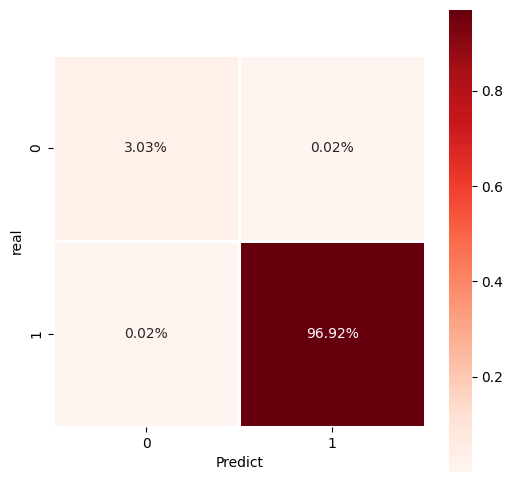

presicion:  0.9922641240333306
recall:  0.9921508494663579
F1-Score:  0.9922074835168694
Pixel_accuracy:  0.9995242621781847
dice:  0.9922074835168694
IoU:  0.9845354746028002
11/11 [==============================] - 1s 67ms/step - loss: 0.0025 - accuracy: 0.9995

result:	 [0.002489177044481039, 0.9995242357254028] 

Epoch 1/500
87/87 - 10s - loss: 6.1805e-04 - accuracy: 0.9998 - val_loss: 1.6112e-04 - val_accuracy: 0.9999 - 10s/epoch - 117ms/step
Epoch 2/500
87/87 - 10s - loss: 3.0552e-04 - accuracy: 0.9999 - val_loss: 1.1214e-04 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 3/500
87/87 - 10s - loss: 1.3396e-04 - accuracy: 1.0000 - val_loss: 8.0241e-05 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 4/500
87/87 - 10s - loss: 6.9084e-05 - accuracy: 1.0000 - val_loss: 1.2815e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 5/500
87/87 - 10s - loss: 5.7347e-05 - accuracy: 1.0000 - val_loss: 5.7718e-05 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 6/500
87/8

Epoch 60/500
87/87 - 9s - loss: 5.9241e-06 - accuracy: 1.0000 - val_loss: 8.9432e-05 - val_accuracy: 1.0000 - 9s/epoch - 109ms/step
Epoch 61/500
87/87 - 9s - loss: 6.2012e-06 - accuracy: 1.0000 - val_loss: 1.0741e-04 - val_accuracy: 1.0000 - 9s/epoch - 109ms/step
Epoch 62/500
87/87 - 9s - loss: 3.3320e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9998 - 9s/epoch - 109ms/step
Epoch 63/500
87/87 - 9s - loss: 1.4254e-04 - accuracy: 1.0000 - val_loss: 2.0280e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 64/500
87/87 - 9s - loss: 7.9723e-05 - accuracy: 1.0000 - val_loss: 1.8237e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 65/500
87/87 - 10s - loss: 4.4948e-05 - accuracy: 1.0000 - val_loss: 1.7832e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 66/500
87/87 - 10s - loss: 2.0990e-05 - accuracy: 1.0000 - val_loss: 1.2315e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 67/500
87/87 - 10s - loss: 1.5331e-05 - accuracy: 1.0000 - val_loss: 1

Epoch 122/500
87/87 - 10s - loss: 1.0649e-06 - accuracy: 1.0000 - val_loss: 1.4175e-04 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 123/500
87/87 - 10s - loss: 7.6971e-07 - accuracy: 1.0000 - val_loss: 1.3475e-04 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 124/500
87/87 - 10s - loss: 1.3387e-06 - accuracy: 1.0000 - val_loss: 1.4985e-04 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 125/500
87/87 - 9s - loss: 1.5988e-06 - accuracy: 1.0000 - val_loss: 1.4590e-04 - val_accuracy: 1.0000 - 9s/epoch - 109ms/step
Epoch 126/500
87/87 - 10s - loss: 1.4983e-06 - accuracy: 1.0000 - val_loss: 1.4219e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 127/500
87/87 - 9s - loss: 1.2131e-06 - accuracy: 1.0000 - val_loss: 1.4952e-04 - val_accuracy: 1.0000 - 9s/epoch - 109ms/step
Epoch 128/500
87/87 - 10s - loss: 9.1833e-07 - accuracy: 1.0000 - val_loss: 1.3943e-04 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 129/500
87/87 - 10s - loss: 8.3180e-07 - accuracy: 1.

Epoch 183/500
87/87 - 10s - loss: 4.5918e-07 - accuracy: 1.0000 - val_loss: 1.8720e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 184/500
87/87 - 10s - loss: 4.8849e-07 - accuracy: 1.0000 - val_loss: 1.8773e-04 - val_accuracy: 0.9999 - 10s/epoch - 111ms/step
Epoch 185/500
87/87 - 10s - loss: 5.3545e-07 - accuracy: 1.0000 - val_loss: 1.9414e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 186/500
87/87 - 10s - loss: 4.3140e-07 - accuracy: 1.0000 - val_loss: 1.8399e-04 - val_accuracy: 0.9999 - 10s/epoch - 111ms/step
Epoch 187/500
87/87 - 10s - loss: 4.4281e-07 - accuracy: 1.0000 - val_loss: 2.0052e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 188/500
87/87 - 10s - loss: 4.8999e-07 - accuracy: 1.0000 - val_loss: 1.8804e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 189/500
87/87 - 10s - loss: 9.2934e-07 - accuracy: 1.0000 - val_loss: 1.8804e-04 - val_accuracy: 0.9999 - 10s/epoch - 111ms/step
Epoch 190/500
87/87 - 10s - loss: 8.1123e-07 - accuracy

Epoch 244/500
87/87 - 9s - loss: 3.1260e-06 - accuracy: 1.0000 - val_loss: 2.9782e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 245/500
87/87 - 10s - loss: 3.3934e-06 - accuracy: 1.0000 - val_loss: 2.9294e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 246/500
87/87 - 9s - loss: 4.3127e-06 - accuracy: 1.0000 - val_loss: 2.9670e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 247/500
87/87 - 9s - loss: 3.4235e-06 - accuracy: 1.0000 - val_loss: 2.9777e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 248/500
87/87 - 9s - loss: 3.0300e-06 - accuracy: 1.0000 - val_loss: 2.8423e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 249/500
87/87 - 9s - loss: 2.1132e-06 - accuracy: 1.0000 - val_loss: 3.1447e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 250/500
87/87 - 10s - loss: 1.3765e-06 - accuracy: 1.0000 - val_loss: 2.7459e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 251/500
87/87 - 9s - loss: 4.8230e-06 - accuracy: 1.0000 - 

Epoch 306/500
87/87 - 10s - loss: 4.1637e-07 - accuracy: 1.0000 - val_loss: 4.8105e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 307/500
87/87 - 10s - loss: 4.0499e-07 - accuracy: 1.0000 - val_loss: 4.7792e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 308/500
87/87 - 10s - loss: 4.7031e-07 - accuracy: 1.0000 - val_loss: 4.7937e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 309/500
87/87 - 10s - loss: 3.9530e-07 - accuracy: 1.0000 - val_loss: 4.8301e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 310/500
87/87 - 10s - loss: 4.5455e-07 - accuracy: 1.0000 - val_loss: 4.8175e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 311/500
87/87 - 9s - loss: 9.4754e-07 - accuracy: 1.0000 - val_loss: 4.8916e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 312/500
87/87 - 10s - loss: 1.5314e-06 - accuracy: 1.0000 - val_loss: 5.1017e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 313/500
87/87 - 10s - loss: 4.5666e-06 - accuracy: 

Epoch 367/500
87/87 - 10s - loss: 1.8240e-06 - accuracy: 1.0000 - val_loss: 5.5386e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 368/500
87/87 - 10s - loss: 1.2551e-06 - accuracy: 1.0000 - val_loss: 5.5154e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 369/500
87/87 - 10s - loss: 9.2019e-07 - accuracy: 1.0000 - val_loss: 5.3064e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 370/500
87/87 - 10s - loss: 6.5635e-07 - accuracy: 1.0000 - val_loss: 5.3904e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 371/500
87/87 - 10s - loss: 5.1631e-07 - accuracy: 1.0000 - val_loss: 5.4180e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 372/500
87/87 - 10s - loss: 4.6433e-07 - accuracy: 1.0000 - val_loss: 5.3817e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 373/500
87/87 - 10s - loss: 4.1876e-07 - accuracy: 1.0000 - val_loss: 5.3001e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 374/500
87/87 - 10s - loss: 4.2460e-07 - accuracy

Epoch 428/500
87/87 - 10s - loss: 9.7485e-06 - accuracy: 1.0000 - val_loss: 6.9779e-04 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 429/500
87/87 - 10s - loss: 6.9944e-06 - accuracy: 1.0000 - val_loss: 6.6682e-04 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 430/500
87/87 - 10s - loss: 7.7807e-06 - accuracy: 1.0000 - val_loss: 7.9192e-04 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 431/500
87/87 - 9s - loss: 7.8012e-06 - accuracy: 1.0000 - val_loss: 7.6286e-04 - val_accuracy: 0.9998 - 9s/epoch - 109ms/step
Epoch 432/500
87/87 - 10s - loss: 9.0065e-06 - accuracy: 1.0000 - val_loss: 7.0078e-04 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 433/500
87/87 - 9s - loss: 8.2831e-06 - accuracy: 1.0000 - val_loss: 8.0256e-04 - val_accuracy: 0.9998 - 9s/epoch - 109ms/step
Epoch 434/500
87/87 - 10s - loss: 5.9664e-06 - accuracy: 1.0000 - val_loss: 7.2392e-04 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 435/500
87/87 - 10s - loss: 3.2815e-06 - accuracy: 1.

Epoch 490/500
87/87 - 10s - loss: 2.7140e-07 - accuracy: 1.0000 - val_loss: 6.6152e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 491/500
87/87 - 10s - loss: 5.1462e-07 - accuracy: 1.0000 - val_loss: 6.6215e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 492/500
87/87 - 10s - loss: 2.1264e-07 - accuracy: 1.0000 - val_loss: 6.7284e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 493/500
87/87 - 10s - loss: 2.6192e-07 - accuracy: 1.0000 - val_loss: 6.6037e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 494/500
87/87 - 10s - loss: 3.4506e-07 - accuracy: 1.0000 - val_loss: 6.6794e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 495/500
87/87 - 9s - loss: 2.3721e-07 - accuracy: 1.0000 - val_loss: 6.6155e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 496/500
87/87 - 9s - loss: 1.8292e-07 - accuracy: 1.0000 - val_loss: 6.6135e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 497/500
87/87 - 10s - loss: 2.2237e-07 - accuracy: 1.

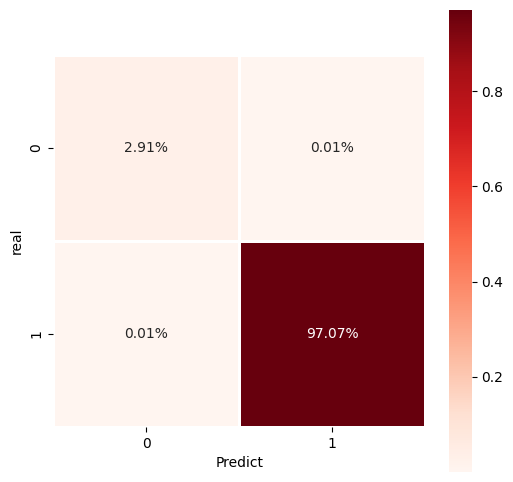

presicion:  0.9973982921678727
recall:  0.9975970466916543
F1-Score:  0.9974976595291486
Pixel_accuracy:  0.9998539311741546
dice:  0.9974976595291487
IoU:  0.9950078112143339
11/11 [==============================] - 1s 68ms/step - loss: 6.6431e-04 - accuracy: 0.9999

result:	 [0.000664310238789767, 0.9998539090156555] 

Epoch 1/500
87/87 - 10s - loss: 3.9507e-04 - accuracy: 0.9999 - val_loss: 2.1328e-04 - val_accuracy: 0.9999 - 10s/epoch - 117ms/step
Epoch 2/500
87/87 - 10s - loss: 2.4023e-04 - accuracy: 0.9999 - val_loss: 8.5338e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 3/500
87/87 - 10s - loss: 7.7233e-05 - accuracy: 1.0000 - val_loss: 3.9924e-05 - val_accuracy: 1.0000 - 10s/epoch - 111ms/step
Epoch 4/500
87/87 - 10s - loss: 2.2743e-05 - accuracy: 1.0000 - val_loss: 2.8159e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 5/500
87/87 - 10s - loss: 8.4345e-06 - accuracy: 1.0000 - val_loss: 2.0929e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 6/500


Epoch 60/500
87/87 - 10s - loss: 3.7232e-06 - accuracy: 1.0000 - val_loss: 3.3008e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 61/500
87/87 - 10s - loss: 7.5840e-06 - accuracy: 1.0000 - val_loss: 8.4698e-05 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 62/500
87/87 - 10s - loss: 1.3505e-05 - accuracy: 1.0000 - val_loss: 5.0529e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 63/500
87/87 - 10s - loss: 1.9197e-05 - accuracy: 1.0000 - val_loss: 1.0031e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 64/500
87/87 - 10s - loss: 2.5155e-05 - accuracy: 1.0000 - val_loss: 7.7484e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 65/500
87/87 - 10s - loss: 2.5903e-05 - accuracy: 1.0000 - val_loss: 7.4386e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 66/500
87/87 - 10s - loss: 2.7625e-05 - accuracy: 1.0000 - val_loss: 1.3439e-04 - val_accuracy: 1.0000 - 10s/epoch - 109ms/step
Epoch 67/500
87/87 - 10s - loss: 2.2771e-05 - accuracy: 1.0000

Epoch 121/500
87/87 - 10s - loss: 2.1054e-07 - accuracy: 1.0000 - val_loss: 6.2472e-05 - val_accuracy: 1.0000 - 10s/epoch - 111ms/step
Epoch 122/500
87/87 - 10s - loss: 2.5862e-07 - accuracy: 1.0000 - val_loss: 6.2763e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 123/500
87/87 - 10s - loss: 1.8845e-07 - accuracy: 1.0000 - val_loss: 6.1983e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 124/500
87/87 - 10s - loss: 2.0073e-07 - accuracy: 1.0000 - val_loss: 6.3201e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 125/500
87/87 - 10s - loss: 2.4709e-07 - accuracy: 1.0000 - val_loss: 6.3349e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 126/500
87/87 - 10s - loss: 2.1080e-07 - accuracy: 1.0000 - val_loss: 6.2783e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 127/500
87/87 - 10s - loss: 1.7076e-07 - accuracy: 1.0000 - val_loss: 6.2112e-05 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 128/500
87/87 - 10s - loss: 1.6068e-07 - accuracy

Epoch 182/500
87/87 - 10s - loss: 4.9231e-05 - accuracy: 1.0000 - val_loss: 2.1454e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 183/500
87/87 - 10s - loss: 7.4339e-05 - accuracy: 1.0000 - val_loss: 7.0496e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 184/500
87/87 - 10s - loss: 6.0178e-05 - accuracy: 1.0000 - val_loss: 3.2348e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 185/500
87/87 - 10s - loss: 5.3031e-05 - accuracy: 1.0000 - val_loss: 1.7141e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 186/500
87/87 - 10s - loss: 2.3875e-05 - accuracy: 1.0000 - val_loss: 1.4300e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 187/500
87/87 - 10s - loss: 1.1429e-05 - accuracy: 1.0000 - val_loss: 1.3702e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 188/500
87/87 - 10s - loss: 5.7801e-06 - accuracy: 1.0000 - val_loss: 1.1089e-04 - val_accuracy: 1.0000 - 10s/epoch - 111ms/step
Epoch 189/500
87/87 - 10s - loss: 3.1810e-06 - accuracy

Epoch 243/500
87/87 - 10s - loss: 1.2097e-06 - accuracy: 1.0000 - val_loss: 1.2585e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 244/500
87/87 - 10s - loss: 7.5446e-07 - accuracy: 1.0000 - val_loss: 1.1437e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 245/500
87/87 - 10s - loss: 4.9720e-07 - accuracy: 1.0000 - val_loss: 1.0899e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 246/500
87/87 - 10s - loss: 5.6513e-07 - accuracy: 1.0000 - val_loss: 1.1799e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 247/500
87/87 - 10s - loss: 5.6550e-07 - accuracy: 1.0000 - val_loss: 1.1612e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 248/500
87/87 - 10s - loss: 7.1276e-07 - accuracy: 1.0000 - val_loss: 1.1363e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 249/500
87/87 - 10s - loss: 8.1888e-07 - accuracy: 1.0000 - val_loss: 1.1886e-04 - val_accuracy: 1.0000 - 10s/epoch - 111ms/step
Epoch 250/500
87/87 - 10s - loss: 7.3617e-07 - accuracy

Epoch 304/500
87/87 - 10s - loss: 1.7625e-07 - accuracy: 1.0000 - val_loss: 1.1973e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 305/500
87/87 - 10s - loss: 4.3306e-07 - accuracy: 1.0000 - val_loss: 1.4685e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 306/500
87/87 - 10s - loss: 6.8072e-07 - accuracy: 1.0000 - val_loss: 1.2704e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 307/500
87/87 - 10s - loss: 1.0555e-06 - accuracy: 1.0000 - val_loss: 1.3244e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 308/500
87/87 - 10s - loss: 3.6768e-06 - accuracy: 1.0000 - val_loss: 1.7421e-04 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 309/500
87/87 - 10s - loss: 5.2920e-06 - accuracy: 1.0000 - val_loss: 2.1796e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 310/500
87/87 - 10s - loss: 1.0536e-05 - accuracy: 1.0000 - val_loss: 2.1483e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 311/500
87/87 - 10s - loss: 2.4667e-05 - accuracy

Epoch 365/500
87/87 - 10s - loss: 3.5516e-06 - accuracy: 1.0000 - val_loss: 2.6919e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 366/500
87/87 - 10s - loss: 2.9902e-06 - accuracy: 1.0000 - val_loss: 3.3122e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 367/500
87/87 - 10s - loss: 2.5827e-06 - accuracy: 1.0000 - val_loss: 2.1721e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 368/500
87/87 - 10s - loss: 5.2420e-06 - accuracy: 1.0000 - val_loss: 6.9418e-04 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 369/500
87/87 - 10s - loss: 1.7368e-05 - accuracy: 1.0000 - val_loss: 3.6423e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 370/500
87/87 - 10s - loss: 4.3407e-05 - accuracy: 1.0000 - val_loss: 3.5445e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 371/500
87/87 - 9s - loss: 5.4668e-05 - accuracy: 1.0000 - val_loss: 3.7822e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 372/500
87/87 - 10s - loss: 4.0006e-05 - accuracy: 

Epoch 426/500
87/87 - 10s - loss: 1.4199e-06 - accuracy: 1.0000 - val_loss: 2.0364e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 427/500
87/87 - 10s - loss: 2.4729e-06 - accuracy: 1.0000 - val_loss: 2.8844e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 428/500
87/87 - 10s - loss: 2.2393e-06 - accuracy: 1.0000 - val_loss: 2.3617e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 429/500
87/87 - 10s - loss: 1.2316e-06 - accuracy: 1.0000 - val_loss: 2.2775e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 430/500
87/87 - 10s - loss: 1.3792e-06 - accuracy: 1.0000 - val_loss: 3.4503e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 431/500
87/87 - 10s - loss: 3.6963e-06 - accuracy: 1.0000 - val_loss: 5.8865e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 432/500
87/87 - 10s - loss: 8.4118e-06 - accuracy: 1.0000 - val_loss: 2.7832e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 433/500
87/87 - 10s - loss: 1.7991e-05 - accuracy

Epoch 487/500
87/87 - 10s - loss: 2.0107e-06 - accuracy: 1.0000 - val_loss: 2.6193e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 488/500
87/87 - 10s - loss: 1.4462e-06 - accuracy: 1.0000 - val_loss: 2.5585e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 489/500
87/87 - 10s - loss: 1.0222e-06 - accuracy: 1.0000 - val_loss: 2.5126e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 490/500
87/87 - 10s - loss: 8.8326e-07 - accuracy: 1.0000 - val_loss: 2.6854e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 491/500
87/87 - 10s - loss: 7.7693e-07 - accuracy: 1.0000 - val_loss: 3.2771e-04 - val_accuracy: 0.9999 - 10s/epoch - 111ms/step
Epoch 492/500
87/87 - 10s - loss: 5.6031e-07 - accuracy: 1.0000 - val_loss: 2.5005e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 493/500
87/87 - 10s - loss: 1.5076e-06 - accuracy: 1.0000 - val_loss: 3.2020e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 494/500
87/87 - 10s - loss: 3.1023e-06 - accuracy

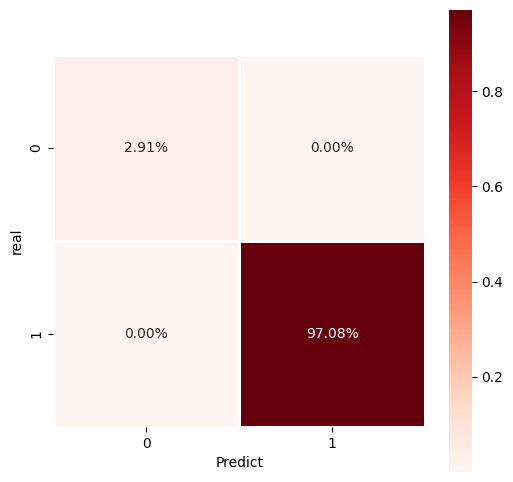

presicion:  0.9983048524445971
recall:  0.9987677923291212
F1-Score:  0.9985362687299887
Pixel_accuracy:  0.9999145485825772
dice:  0.9985362687299886
IoU:  0.9970768162154905
11/11 [==============================] - 1s 66ms/step - loss: 3.1826e-04 - accuracy: 0.9999

result:	 [0.0003182609216310084, 0.9999145865440369] 



In [16]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
num_folds=5
x2 = np.concatenate((x_train,x_test))
y2 = np.concatenate((y_train,y_test))

all_history=[]
all_iou = []
all_precision=[]
all_recall=[]
all_F1=[]
all_dice=[]
all_paccuracy=[]

for train, test in KFold(num_folds).split(x2):
    xtrain,xtest=x2[train],x2[test]
    ytrain,ytest=y2[train],y2[test]
    histt = model.fit(xtrain,ytrain,epochs=500,shuffle=True,verbose=2,batch_size=16,validation_data=(xtest,ytest))
    all_history.append(histt)
    
    pred = model.predict(xtest)
    pred = pred > 0.5
    FP = len(np.where(pred - ytest == 1.)[0])
    FN = len(np.where(pred - ytest == -1.)[0])
    TP = len(np.where(pred + ytest == 2.)[0])
    TN = len(np.where(pred + ytest == 0.)[0])
    cmat = [[TP,FN],[FP,TN]]
    print(cmat)
    plt.figure(figsize=(6,6))
    sns.heatmap(cmat/np.sum(cmat),cmap="Reds",annot=True,fmt='.2%',square=1,linewidth=2.)
    plt.xlabel('Predict')
    plt.ylabel('real')
    plt.show()
    presicion = TP / (TP+FP)
    recall = TP / (TP+FN)
    F1 = 2 * (presicion*recall)/(presicion+recall)
    Pixel_accuracy=(TP+TN)/(TP+TN+FP+FN)
    dice=(2*TP)/(2*TP+FP+FN)
    iou=TP/(TP+FP+FN)

    print("presicion: ",presicion)
    print("recall: ",recall)
    print("F1-Score: ",F1)
    print("Pixel_accuracy: ",Pixel_accuracy)
    print("dice: ",dice)
    print("IoU: ",iou)
    
    all_iou.append(iou)
    all_precision.append(presicion)
    all_recall.append(recall)
    all_F1.append(F1)
    all_dice.append(dice)
    all_paccuracy.append(Pixel_accuracy)
    
    print("\nresult:\t",model.evaluate(xtest,ytest.astype('float32')),'\n')

In [17]:
def Plot_ACC_LOSS(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss,'y',label='Traning loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title('Traning and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

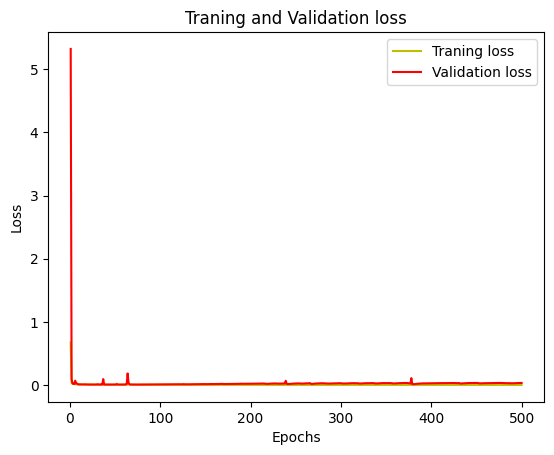

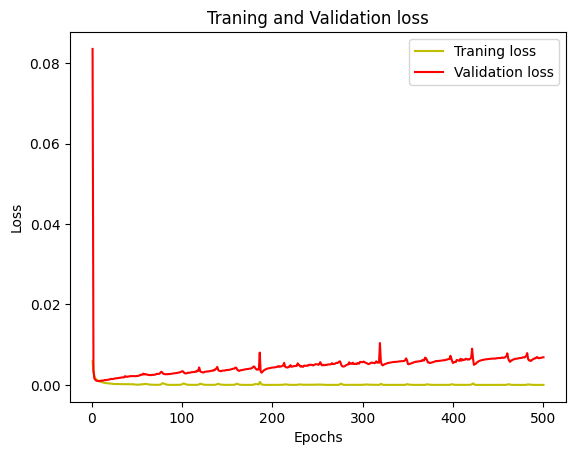

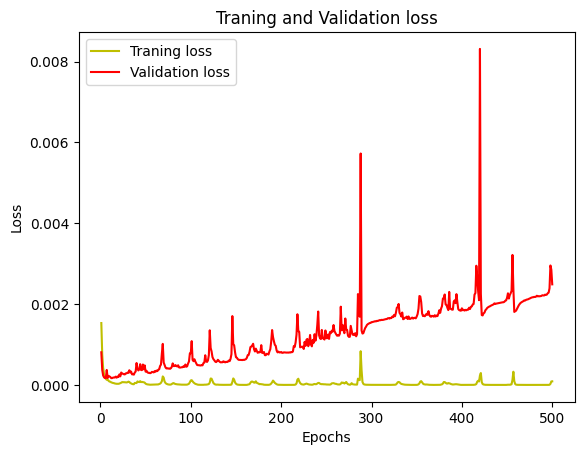

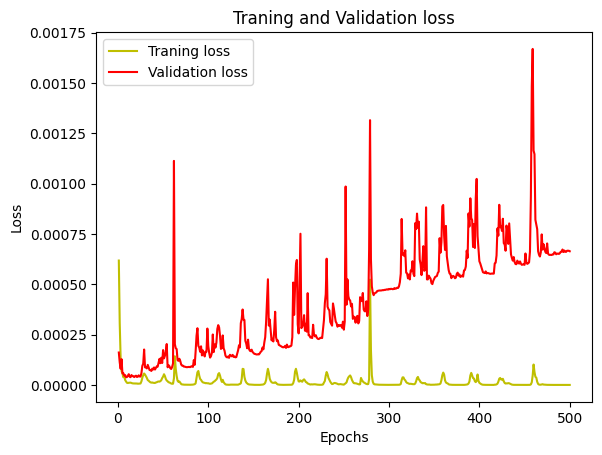

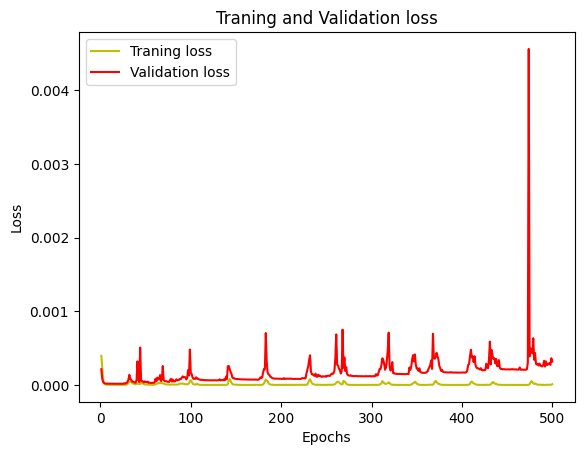

In [18]:
for i in range (len(all_history)) :
     Plot_ACC_LOSS(all_history[i])

In [19]:
model.save("seg-2class-500epoc.hdf5")

In [20]:
all_iou

[0.9289872345437576,
 0.9694577383717784,
 0.9845354746028002,
 0.9950078112143339,
 0.9970768162154905]

In [21]:
np.mean(np.array(all_iou))


0.9750130149896321

In [23]:
print("all_iou",all_iou)
print("*****************************************")
print("all_precision",all_precision)
print("*****************************************")
print("all_recall",all_recall)
print("*****************************************")
print("all_F1",all_F1)
print("*****************************************")
print("all_dice",all_dice)
print("*****************************************")
print("all_paccuracy",all_paccuracy)

all_iou [0.9289872345437576, 0.9694577383717784, 0.9845354746028002, 0.9950078112143339, 0.9970768162154905]
*****************************************
all_precision [0.9651760374605418, 0.9849629020211479, 0.9922641240333306, 0.9973982921678727, 0.9983048524445971]
*****************************************
all_recall [0.9612051541182416, 0.9840216383038278, 0.9921508494663579, 0.9975970466916543, 0.9987677923291212]
*****************************************
all_F1 [0.9631865031636468, 0.9844920451791609, 0.9922074835168694, 0.9974976595291486, 0.9985362687299887]
*****************************************
all_dice [0.9631865031636468, 0.9844920451791609, 0.9922074835168694, 0.9974976595291487, 0.9985362687299886]
*****************************************
all_paccuracy [0.9978322544317136, 0.999100226146687, 0.9995242621781847, 0.9998539311741546, 0.9999145485825772]


In [24]:
print("all_iou",np.mean(all_iou))
print("*****************************************")
print("all_precision",np.mean(all_precision))
print("*****************************************")
print("all_recall",np.mean(all_recall))
print("*****************************************")
print("all_F1",np.mean(all_F1))
print("*****************************************")
print("all_dice",np.mean(all_dice))
print("*****************************************")
print("all_accuracy",np.mean(all_paccuracy))

all_iou 0.9750130149896321
*****************************************
all_precision 0.9876212416254979
*****************************************
all_recall 0.9867484961818406
*****************************************
all_F1 0.987183992023763
*****************************************
all_dice 0.987183992023763
*****************************************
all_paccuracy 0.9992450445026634


In [ ]:
# without kfold

In [ ]:
def showsingleimage(img):
    print("min:",np.min(img))
    print("max:",np.max(img))
    plt.imshow(img)
    plt.show()

In [ ]:
history = model.fit(x_train,y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=50,
                    validation_data=(x_test,y_test),
                    #class_weight=class_weights,
                    shuffle=False)

In [ ]:
Plot_ACC_LOSS(history)
# model.save("seg-5class.hdf5")

In [ ]:

#n_class=1
_,acc = model.evaluate(x_test,y_test)
print("Accuracy is :",(acc * 100.0),"%")


# model.load_weights("seg-5class.hdf5")

y_pred = model.predict(x_test)

y_pred_th = y_pred > 0.5
intersection = np.logical_and(y_test,y_pred_th)
union = np.logical_or(y_test,y_pred_th)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is:",iou_score) 


In [ ]:
import seaborn as sns
pred = model.predict(x_test)
pred = pred > 0.5
FP = len(np.where(pred - y_test == 1.)[0])
FN = len(np.where(pred - y_test == -1.)[0])
TP = len(np.where(pred + y_test == 2.)[0])
TN = len(np.where(pred + y_test == 0.)[0])
cmat = [[TP,FN],[FP,TN]]
print(cmat)
plt.figure(figsize=(6,6))
sns.heatmap(cmat/np.sum(cmat),cmap="Reds",annot=True,fmt='.2%',square=1,linewidth=2.)
plt.xlabel('Predict')
plt.ylabel('real')
plt.show()
presicion = TP / (TP+FP)
recall = TP / (TP+FN)
F1 = 2 * (presicion*recall)/(presicion+recall)
Pixel_accuracy=(TP+TN)/(TP+TN+FP+FN)
dice=(2*TP)/(2*TP+FP+FN)
iou=TP/(TP+FP+FN)

print("presicion: ",presicion)
print("recall: ",recall)
print("F1-Score: ",F1)
print("Pixel_accuracy: ",Pixel_accuracy)
print("dice: ",dice)
print("IoU: ",iou)

In [3]:
n_test_img = np.random.randint(0,len(x_test)-1)
test_img = x_test[n_test_img]
GT = y_test[n_test_img]
test_img_input = np.expand_dims(test_img,axis=0)
prediction = (model.predict(test_img_input)[0] > 0.5).astype(np.uint8)

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('GT Image')
plt.imshow(GT)
plt.subplot(133)
plt.title('Prediction Image')
plt.imshow(prediction)
plt.show()

NameError: name 'x_test' is not defined